<a href="https://colab.research.google.com/github/JakobWyatt/autonomous-wheelchair-thesis/blob/main/TrainSegModels_HybridNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch==1.12.0 torchvision timm webcolors albumentations efficientnet-pytorch pretrainedmodels
!git clone https://github.com/datvuthanh/HybridNets
!git clone https://github.com/hustvl/YOLOP
!mkdir datasets
!unzip drive/MyDrive/Thesis/datasets/bdd100k/bdd100k_images_100k.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/det_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/da_seg_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/bdd100k/ll_seg_annotations.zip -d datasets/
!unzip drive/MyDrive/Thesis/datasets/cityscapes/gtFine_trainvaltest.zip -d datasets/
!unzip -o drive/MyDrive/Thesis/datasets/cityscapes/leftImg8bit_trainvaltest.zip -d datasets/

Streaming output truncated to the last 5000 lines.
 extracting: datasets/leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/jena_000107_000019_leftImg8bit.png  
 extracting: datasets/leftImg8bit/train/jena/je

In [10]:
import torch
import sys
sys.path.insert(0, "./HybridNets")
from hybridnets.model import ModelWithLoss
import seaborn as sns
from hybridnets.dataset import BddDataset
from torchvision.datasets import Cityscapes
from utils.utils import Params
from torchvision import transforms
import PIL
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from pprint import pprint

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(device))
print(torch.cuda.memory_summary())

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  128346 KB |    1210 MB |    7787 GB |    7787 GB |
|       from large pool |   99663 KB |    1181 MB |    7725 GB |    7724 GB |
|       from small pool |   28683 KB |      32 MB |      62 GB |      62 GB |
|---------------------------------------------------------------------------|
| Active memory         |

In [3]:
model = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True, device=device)
model.eval()

Using cache found in /root/.cache/torch/hub/datvuthanh_hybridnets_main


HybridNetsBackbone(
  (bifpn): Sequential(
    (0): BiFPN(
      (conv6_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), groups=160, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv5_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), groups=160, bias=False)
        )
        (pointwise_conv): Conv2dStaticSamePadding(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      )
      (conv4_up): SeparableConvBlock(
        (depthwise_conv): Conv2dStaticSamePaddi

In [4]:
# Standard transform - only needs to be tuned to each dataset for final performance metrics
params = Params('./HybridNets/projects/bdd100k.yml')
params.dataset['dataroot'] = "./datasets/bdd100k/images/100k"
dataset_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=params.mean, std=params.std
    )
])

In [6]:
bdd_train_dataset = BddDataset(
    params=params,
    is_train=True,
    inputsize=params.model['image_size'],
    transform=dataset_transforms
)
bdd_test_dataset = BddDataset(
    params=params,
    is_train=False,
    inputsize=params.model['image_size'],
    transform=dataset_transforms
)
bdd_train_loader = DataLoader(bdd_train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=BddDataset.collate_fn)
bdd_test_loader = DataLoader(bdd_test_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=BddDataset.collate_fn)
optimizer = torch.optim.AdamW(model.parameters())

building database...


  0%|          | 0/70000 [00:00<?, ?it/s]

database build finish
building database...


  0%|          | 0/10000 [00:00<?, ?it/s]

database build finish


In [5]:
# make segmentation pretty again
def colorfill_segmentation(seg):
    colors = np.array([[0, 0, 0], [0, 128, 0], [0, 0, 128]], dtype=np.uint8)
    seg_mask = seg.byte().cpu().numpy()
    seg_mask = PIL.Image.fromarray(seg_mask)
    seg_mask.putpalette(colors)
    seg_mask = seg_mask.convert("RGB")
    seg_mask = np.array(seg_mask, dtype=np.uint8)
    return seg_mask

# Measure IoU from our test set
def confusionMatrix(output, target):
    output = torch.where(output == 1, 1, 0) # just drivable area
    target = torch.where(target == 1, 1, 0)

    tp = (output * target).sum([1,2])
    fp = output.sum([1,2]) - tp
    fn = target.sum([1,2]) - tp
    tn = torch.prod(torch.tensor(target.shape)) - tp - fp - fn
    return tn, fp, fn, tp

# A 3x2 confusion matrix:
#           Prediction
# Actual    tn  fp
#           fnrd tprd (road)
#           fnsw tpsw (path)
def confusionMatrixCityscapes(output, target):
    output = torch.where(output == 1, 1, 0) # just drivable area
    target_rd = torch.where(target == 7, 1, 0) # road
    target_sw = torch.where(target == 8, 1, 0) # sidewalk

    tprd = (output * target_rd).sum([1,2])
    tpsw = (output * target_sw).sum([1,2])
    fp = output.sum([1,2]) - tprd - tpsw
    fnrd = target_rd.sum([1,2]) - tprd
    fnsw = target_sw.sum([1,2]) - tpsw
    tn = torch.prod(torch.tensor(target.shape)) - tprd - tpsw - fnrd - fnsw - fp
    return tn, fp, fnrd, tprd, fnsw, tpsw

def iou(tn, fp, fn, tp):
    return tp / (tp + fn + fp)

def iouCityscapes(tn, fp, fnrd, tprd, fnsw, tpsw):
    return (tprd + tpsw) / (fp + tprd + tpsw + fnrd + fnsw)

  0%|          | 0/4375 [00:03<?, ?it/s]


1.5153373


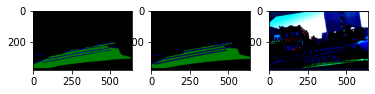

In [55]:
# Get an idea of our initial loss - this doesn't do anything
modelWithLoss = ModelWithLoss(model)
with torch.no_grad():
    for data in tqdm(bdd_train_loader):
        seg_annot = data['segmentation'].to(device)
        cls_loss, reg_loss, seg_loss, regression, classification, anchors, segmentation = modelWithLoss(
            data['img'].to(device), data['annot'].to(device), seg_annot, obj_list=params.obj_list)
        break

fig, ax = plt.subplots(1, 3)
ax[0].imshow(colorfill_segmentation(segmentation[0].argmax(0)))
ax[1].imshow(colorfill_segmentation(seg_annot[0]))
ax[2].imshow(data['img'][0].permute(1, 2, 0))
print(seg_loss.cpu().numpy())

In [ ]:
tn_l = []
fp_l = []
fn_l = []
tp_l = []
# find our IoU on the BDD dataset
with torch.no_grad():
    for data in tqdm(bdd_test_loader):
        seg_annot = data['segmentation'].to(device)
        features, regression, classification, anchors, segmentation = model(data['img'].to(device))
        tn, fp, fn, tp = confusionMatrix(segmentation.argmax(1), seg_annot)

        tn_l.extend(tn.cpu().tolist())
        fp_l.extend(fp.cpu().tolist())
        fn_l.extend(fn.cpu().tolist())
        tp_l.extend(tp.cpu().tolist())

100%|██████████| 625/625 [07:29<00:00,  1.39it/s]


In [ ]:
tn_s = np.array(tn_l).sum()
fp_s = np.array(fp_l).sum()
fn_s = np.array(fn_l).sum()
tp_s = np.array(tp_l).sum()
cfn = np.array([[tn_s, fp_s], [fn_s, tp_s]])
cfn = cfn / cfn.sum()
iou(tn_s, fp_s, fn_s, tp_s)
#sns.heatmap(cfn, annot=True)

0.8572281169979448

In [31]:
cs_train_dataset = Cityscapes("datasets/", split="train", target_type="instance", transform=dataset_transforms, target_transform=transforms.ToTensor())
cs_val_dataset = Cityscapes("datasets/", split="val", target_type="instance", transform=dataset_transforms, target_transform=transforms.ToTensor())
cs_train_loader = DataLoader(cs_train_dataset, batch_size=2, shuffle=True, num_workers=2)
cs_val_loader = DataLoader(cs_val_dataset, batch_size=2, shuffle=True, num_workers=2)

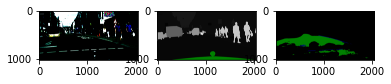

In [9]:
# view Cityscapes dataset
# Road - id 7
# Sidewalk - id 8
img, seg = cs_train_dataset[0]
fig, ax = plt.subplots(1, 3)
img_gpu = img.unsqueeze(0).to(device)
with torch.no_grad():
    features, regression, classification, anchors, segmentation = model(img_gpu)

ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(colorfill_segmentation(seg.squeeze(0)))
ax[2].imshow(colorfill_segmentation(segmentation[0].argmax(0)))

In [29]:
tn, fp, fnrd, tprd, fnsw, tpsw = confusionMatrixCityscapes(segmentation.argmax(1).cpu(), seg)
iouCityscapes(tn, fp, fnrd, tprd, fnsw, tpsw)
print(confusionMatrixCityscapes(segmentation.argmax(1).cpu(), seg))

(tensor([1216503]), tensor([854]), tensor([520163]), tensor([227315]), tensor([132317]), tensor([0]))


In [32]:
tn_l = []
fp_l = []
fnrd_l = []
tprd_l = []
fnsw_l = []
tpsw_l = []
# find our IoU on the Cityscapes dataset
with torch.no_grad():
    for img, seg in tqdm(cs_val_loader):
        seg_annot = seg.squeeze(1).to(device)
        features, regression, classification, anchors, segmentation = model(img.to(device))
        tn, fp, fnrd, tprd, fnsw, tpsw = confusionMatrixCityscapes(segmentation.argmax(1), seg_annot)

        tn_l.extend(tn.cpu().tolist())
        fp_l.extend(fp.cpu().tolist())
        fnrd_l.extend(fnrd.cpu().tolist())
        tprd_l.extend(tprd.cpu().tolist())
        fnsw_l.extend(fnsw.cpu().tolist())
        tpsw_l.extend(tpsw.cpu().tolist())

100%|██████████| 250/250 [01:26<00:00,  2.89it/s]


In [34]:
tn_s = np.array(tn_l).sum()
fp_s = np.array(fp_l).sum()
fnrd_s = np.array(fnrd_l).sum()
tprd_s = np.array(tprd_l).sum()
fnsw_s = np.array(fnsw_l).sum()
tpsw_s = np.array(tpsw_l).sum()
cfn = np.array([[tn_s, fp_s], [fnrd_s, tprd_s], [fnsw_s, tpsw_s]])
cfn = cfn
pprint(cfn)
print(iouCityscapes(tn_s, fp_s, fnrd_s, tprd_s, fnsw_s, tpsw_s))
print(f"Recall of road detection (true positive rate): {tprd_s/(tprd_s + fnrd_s)}")
print(f"Recall of sidewalk detection (true positive rate): {tpsw_s/(tpsw_s + fnsw_s)}")

array([[1698185267,    4133639],
       [ 239773203,  105491239],
       [  48817371,     751281]])
0.26629418247761527
Recall of road detection (true positive rate): 0.30553751318532824
Recall of sidewalk detection (true positive rate): 0.0151563734273024


In [ ]:
# Kill
os.kill(os.getpid(), 9)
#torch.cuda.empty_cache()